In [1]:
%matplotlib inline
import numpy as np
from astropy.table import Table, hstack
import matplotlib.pyplot as plt
from time import time
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import spatial
%cd ..
from starlight.models import SimpleHRDModel
from starlight.models_cy import *

/Users/bl/Dropbox/repos/Starlight


In [2]:
%cd Starlight

/Users/bl/Dropbox/repos/Starlight/starlight


In [3]:
data_tgas = Table.read('/Users/bl/Downloads/tgas-source.fits')
data_2mass = Table.read('/Users/bl/Downloads/tgas-matched-2mass-cut.fits')
data_2mass.rename_column('matched', 'matched_2mass')
data_wise = Table.read('/Users/bl/Downloads/tgas-matched-wise-cut.fits')
data_wise.rename_column('matched', 'matched_wise')
data_apass = Table.read('/Users/bl/Downloads/tgas-matched-apass-dr9.fits')
data_apass.rename_column('matched', 'matched_apass')
data_apass.rename_column('matchdist', 'matchdist_apass')
#data_join = hstack((data_apass, data_wise, data_2mass,
#                    data_tgas['parallax', 'parallax_error']))
data_join = hstack((data_apass, data_tgas['parallax', 'parallax_error', 'phot_g_mean_mag']))
len(data_join), data_join.colnames

(2057050,
 ['ra',
  'dec',
  'bmag',
  'vmag',
  'gmag',
  'rmag',
  'imag',
  'e_bmag',
  'e_vmag',
  'e_gmag',
  'e_rmag',
  'e_imag',
  'matched_apass',
  'matchdist_apass',
  'parallax',
  'parallax_error',
  'phot_g_mean_mag'])

In [4]:
data_join['b-v'] = data_join['bmag'] - data_join['vmag']
data_join['V'] = data_join['vmag'] + 5*np.log10(data_join['parallax']) - 10
data_join['G'] = data_join['phot_g_mean_mag'] + 5*np.log10(data_join['parallax']) - 10

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


In [5]:
ind = np.repeat(True, len(data_join))
ind &= data_join['matched_apass']
#ind &= data_join['matched_wise']
ind &= (data_join['parallax'] / data_join['parallax_error'] > 1/0.1) 
ind &= np.isfinite(data_join['vmag'])
ind &= np.isfinite(data_join['bmag'])
ind &= np.isfinite(data_join['e_vmag'])
ind &= np.isfinite(data_join['e_bmag'])
ind &= data_join['e_vmag'] > 0
ind &= data_join['e_bmag'] > 0
#ind &= np.abs(data_join['b-v'] - 1) < 0.2
#ind &= np.isfinite(data_join['v-w1'])
print('Number of objects=', ind.sum())
df = data_join[ind].to_pandas()
df.describe()

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater


Number of objects= 305228


,ra,dec,bmag,vmag,gmag,rmag,imag,e_bmag,e_vmag,e_gmag,e_rmag,e_imag,matchdist_apass,parallax,parallax_error,phot_g_mean_mag,b-v,V,G
count,305228.000000,305228.000000,305228.000000,305228.000000,302611.000000,297789.000000,289225.000000,305228.000000,305228.000000,302611.000000,297789.000000,289225.000000,305228.000000,305228.000000,305228.000000,305228.000000,305228.000000,305228.000000,305228.000000
mean,173.522929,0.346470,11.729415,11.066548,11.400025,10.911583,10.785854,0.057053,0.046953,0.072913,0.043041,0.070987,0.000056,5.133203,0.299116,10.838653,0.662735,4.374382,4.146201
std,103.656230,43.478437,0.910603,0.845757,0.840068,0.817497,0.818095,0.083227,0.070411,0.117988,0.068739,0.147840,0.000047,3.231911,0.090483,0.841332,0.194324,1.088603,1.049590
min,0.001560,-88.639175,6.106000,5.828000,6.555000,5.763000,4.594000,0.001000,0.001000,0.000000,0.000000,0.000000,0.000000,2.085042,0.204880,4.849242,-1.674000,-0.888678,-1.496348
25%,82.330829,-36.717320,11.137000,10.528000,10.857000,10.410000,10.320000,0.021000,0.021000,0.019000,0.018000,0.024000,0.000025,3.324205,0.244899,10.323487,0.542999,3.695735,3.501410
50%,165.881636,0.630806,11.802000,11.124000,11.446000,10.965000,10.845000,0.034000,0.035000,0.037000,0.033000,0.043000,0.000042,4.225575,0.271307,10.906442,0.644000,4.332368,4.129976
75%,264.445263,37.397246,12.419000,11.715000,12.037000,11.529000,11.377000,0.060000,0.056000,0.080000,0.053000,0.070000,0.000071,5.807221,0.317718,11.476507,0.762000,5.021970,4.791996
max,359.999214,88.673522,15.445000,14.082000,18.309000,15.828000,14.747000,3.538000,4.556000,4.314000,3.848000,3.572000,0.000278,120.594218,0.999963,13.632426,3.037001,12.171859,12.138791


In [6]:
nobj = len(df)
sel = np.random.choice(len(df), nobj, replace=False)

varpi = df[['parallax']].values[sel, :].ravel().astype(np.double)
varpi_err = df[['parallax_error']].values[sel, :].ravel().astype(np.double)
varpi_err = np.sqrt(varpi_err**2 + 0.3**2)

obsmags = df[['vmag']].values[sel, :].astype(np.double).ravel()
obsmags_err = df[['e_vmag']].values[sel, :].astype(np.double).ravel()

ncols = 1
obscolors = df[['bmag']].values[sel, :].astype(np.double) - obsmags[:, None]
obscolors_err = np.sqrt(df[['e_bmag']].values[sel, :].astype(np.double)**2 + obsmags_err[:, None]**2)

obsabsmag = obsmags + 5*np.log10(varpi) - 10
obscolors.min(), obscolors.max(), obsabsmag.min(), obsabsmag.max()

(-1.6739997863769531,
 3.0370006561279297,
 -0.88867781598949769,
 12.171858556236053)

In [7]:
# Construct tiling of mag-color space
nbins_perdim = 30
finenbins_perdim = 200
nbins = nbins_perdim**(ncols+1)
lines = [np.linspace(-2, 12, nbins_perdim), np.linspace(-1.0, 2.5, nbins_perdim)]
flines = [np.linspace(-2, 12, finenbins_perdim), np.linspace(-1.0, 2.5, finenbins_perdim)]
mugrids = np.meshgrid(*lines)
siggrids = np.meshgrid(*[np.repeat((l[1]-l[0])/2, nbins_perdim) for l in lines])

binmus = np.vstack([g.ravel() for g in mugrids]).T
binsigs = np.vstack([g.ravel() for g in siggrids]).T

fgrids = np.meshgrid(*flines)
xfine = np.vstack([g.ravel() for g in fgrids]).T

In [8]:
distances = 1./varpi
probgrid = np.zeros((nobj, nbins))
binamps = np.repeat(1./nbins, nbins)
prob_bingrid_marg(
    probgrid, nobj, nbins, ncols,
    varpi, varpi_err, obsmags, obsmags_err,
    obscolors, obscolors_err,
    distances, binamps, binmus, binsigs)
bins = np.argmax(probgrid, axis=1)
bincounts = np.bincount(bins, minlength=nbins)
binamps = np.random.dirichlet(bincounts)
print((probgrid.sum(axis=1) == 0).sum())

def hrd(x, amps, mus, sigs):
    nbins = amps.size
    npoints, ndim = x.shape
    y = np.zeros((npoints, ))
    for b in range(nbins):
        y += amps[b] / nbins * np.prod(
            np.exp(-0.5*((x-mus[b, None, :])/sigs[b, None, :])**2) / 
                sigs[b, None, :]/np.sqrt(2*np.pi), axis=1)
    return y

naive_model = hrd(xfine, binamps, binmus, binsigs).reshape(fgrids[0].shape)

0


In [9]:
logdist_err = 5*np.vstack([np.log10(1./(varpi + varpi_err*np.random.randn(nobj))) for i in range(100)]).std(axis=0)

In [10]:
# Arbitrary cut but 0 or 1 should be reasonnable
selection = np.where(bincounts > 0)[0]
binamps_selection = np.repeat(0, nbins)
binamps_selection[selection] = 1
selectionfct_model = hrd(xfine, binamps_selection, binmus, binsigs).reshape(fgrids[0].shape)
print(selection.size, nbins)

import scipy.ndimage.filters
binamps_selection2 = 1 - scipy.ndimage.filters.uniform_filter(1-binamps_selection.reshape(mugrids[0].shape), 
                                                          2, mode='nearest').ravel()
selectionfct_model2 = hrd(xfine, binamps_selection2, binmus, binsigs).reshape(fgrids[0].shape)
selection = np.where(binamps_selection > 0)[0]
print(selection.size, nbins)

410 900
410 900


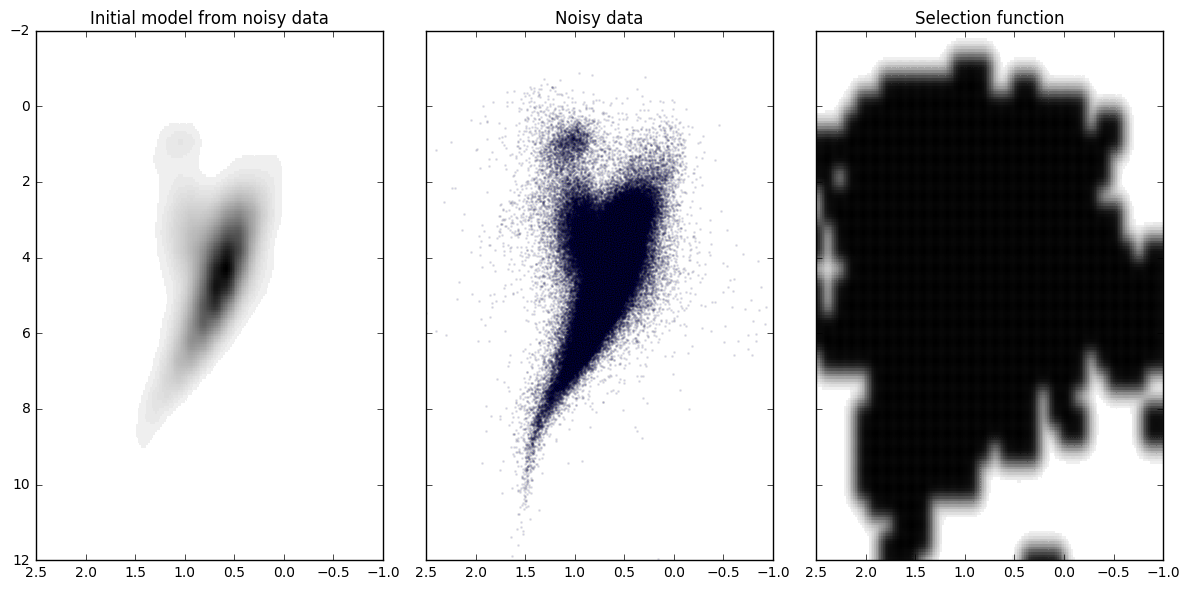

In [11]:
cmap = plt.cm.gray_r
cmap.set_gamma(0.5)
fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharex=True, sharey=True)
axs = axs.ravel()
axs[0].pcolormesh(fgrids[1], fgrids[0], naive_model, cmap=cmap)
axs[0].set_title('Initial model from noisy data')
axs[1].scatter(obscolors, obsabsmag, s=1, alpha=0.1)
axs[1].set_title('Noisy data')
axs[2].pcolormesh(fgrids[1], fgrids[0], selectionfct_model2, cmap=cmap)
axs[2].set_title('Selection function')
axs[-1].set_ylim(lines[0][-1], lines[0][0])
axs[-1].set_xlim(lines[1][-1], lines[1][0])
fig.tight_layout()

In [12]:
# validation : random subset of object. Add noise
# in the rest:
# training 1: all objects
# training 2: best objects
# training 3: worst objects
inds = np.arange(nobj)
np.random.shuffle(inds)
frac = 0.1
lim = int(frac*nobj)
ind_validation = inds[:lim]
ind_validation = ind_validation[np.argsort((varpi_err/varpi)[ind_validation])]
ind_training = inds[lim:]
ind_training_sorted = ind_training[np.argsort((varpi_err/varpi)[ind_training])]
ind_training_best, ind_training_worst = np.split(ind_training_sorted[:], 2)

(array([  4.88900000e+03,   1.45040000e+04,   2.14050000e+04,
          2.54120000e+04,   2.66150000e+04,   2.43890000e+04,
          1.57890000e+04,   4.09100000e+03,   2.55000000e+02,
          4.00000000e+00]),
 array([ 0.00109527,  0.01135939,  0.02162351,  0.03188763,  0.04215175,
         0.05241587,  0.06268   ,  0.07294412,  0.08320824,  0.09347236,
         0.10373648]),
 <a list of 1 Patch objects>)

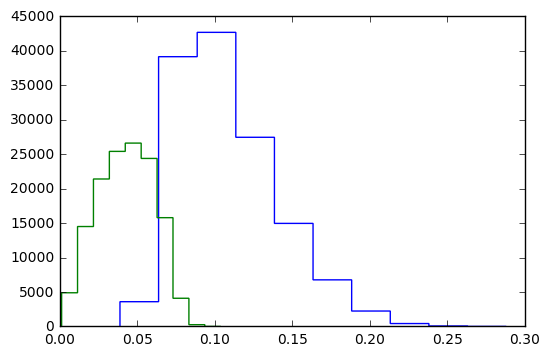

In [13]:
plt.hist(logdist_err[ind_training_worst] / np.abs(5*np.log10(1/varpi[ind_training_worst])), histtype='step')
plt.hist(logdist_err[ind_training_best] / np.abs(5*np.log10(1/varpi[ind_training_best])), histtype='step')

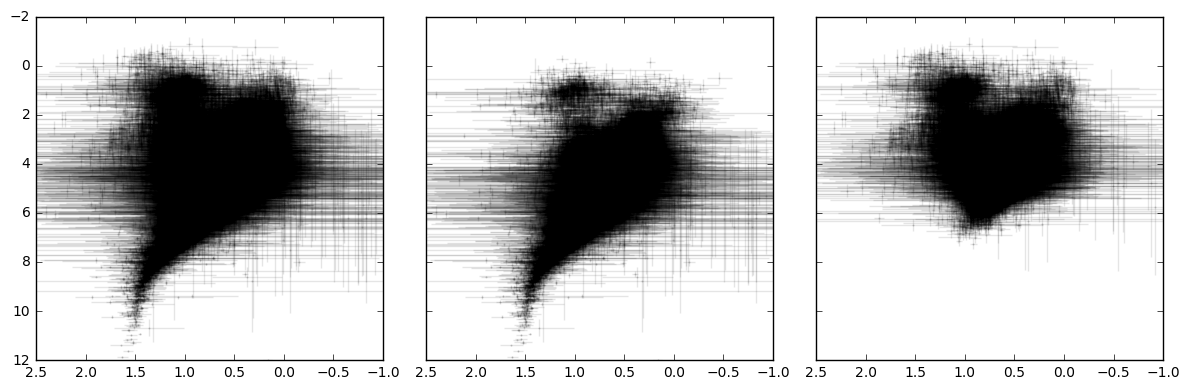

In [14]:
cmap = plt.cm.gray_r
cmap.set_gamma(0.5)
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
axs = axs.ravel()
yerr = np.sqrt(obsmags_err**2 + (logdist_err)**2)
xerr = obscolors_err
args = {'fmt': 'o', 'markersize': 1, 'color': 'k', 'lw': 1, 'capsize': 0, 'alpha': 0.1}
axs[0].errorbar(obscolors[ind_training],
                obsabsmag[ind_training], 
                yerr=yerr[ind_training],
                xerr=xerr[ind_training],
                **args)
axs[1].errorbar(obscolors[ind_training_best],
                obsabsmag[ind_training_best], 
                yerr=yerr[ind_training_best],
                xerr=xerr[ind_training_best], 
                **args)
axs[2].errorbar(obscolors[ind_training_worst],
                obsabsmag[ind_training_worst], 
                yerr=yerr[ind_training_worst],
                xerr=xerr[ind_training_worst], 
                **args)
axs[-1].set_ylim(lines[0][-1], lines[0][0])
axs[-1].set_xlim(lines[1][-1], lines[1][0])
fig.tight_layout()

In [15]:
# Apply selection function and drop unused bins
binamps_sel = binamps[selection]
binmus_sel, binsigs_sel = binmus[selection, :], binsigs[selection, :]
nbins_sel = selection.size

In [20]:
model = SimpleHRDModel()
num_samples = 1000
num_steps = 30

In [ ]:
model.set_data(binmus_sel, binsigs_sel,
               varpi[ind_training], varpi_err[ind_training],
               obsmags[ind_training], obsmags_err[ind_training],
               obscolors[ind_training, :], obscolors_err[ind_training, :])
distances_samples, bins_samples, binamps_samples =\
            model.gibbs_sampler(num_samples, num_steps=num_steps)

In [ ]:
# shrinkage of distances in training set
# TODO: better representation of bin locations (in 2D plane with sample average)
distances_samples2 = np.vstack([1/(varpi[ind_training] + varpi_err[ind_training]*np.random.randn(ind_training.size)) for i in range(num_samples)])
distances = distances_samples.mean(axis=0)
distances2 = distances_samples2.mean(axis=0)
fig, axs = plt.subplots(8, 2, figsize=(10, 12))
varpi_fracerror = varpi_err / varpi
js = np.where(varpi_fracerror[ind_training] > 0.02)[0]
for i in range(axs.shape[0]):
    axs[i, 0].hist(bins_samples[:, js[i]], histtype='step')
    axs[i, 1].hist(distances_samples[:, js[i]], 30, normed=True, color='b', histtype='step')#, range=[0., 0.4]
    axs[i, 1].hist(distances_samples2[:, js[i]], 30, normed=True, color='r', histtype='step')#, range=[0., 0.4]
    axs[i, 1].axvline(distances[js[i]], c='b', lw=2)
    axs[i, 1].axvline(distances2[js[i]], c='r', lw=2, ls='--')

In [ ]:
model.set_data(binmus_sel, binsigs_sel,
               varpi[ind_training_best], varpi_err[ind_training_best],
               obsmags[ind_training_best], obsmags_err[ind_training_best],
               obscolors[ind_training_best, :], obscolors_err[ind_training_best, :])
distances_samples_best, bins_samples_best, binamps_samples_best =\
            model.gibbs_sampler(num_samples, num_steps=num_steps)
print(np.isfinite(distances_samples).sum() / num_samples, distances_samples.shape)

In [ ]:
model.set_data(binmus_sel, binsigs_sel,
               varpi[ind_training_worst], varpi_err[ind_training_worst],
               obsmags[ind_training_worst], obsmags_err[ind_training_worst],
               obscolors[ind_training_worst, :], obscolors_err[ind_training_worst, :])
distances_samples_worst, bins_samples_worst, binamps_samples_worst =\
            model.gibbs_sampler(num_samples, num_steps=num_steps)

In [ ]:
distances_inf = distances_samples.mean(axis=0)
bins_sel_inf = bins_samples.mean(axis=0).astype(int)
binamps_inf, binamps_inf_std = 0*binamps, 0*binamps
binamps_inf[selection] = binamps_samples.mean(axis=0)
binamps_inf_std[selection] = binamps_samples.std(axis=0)
inf_model = hrd(xfine, binamps_inf, binmus, binsigs).reshape(fgrids[0].shape)
inf_model_std = hrd(xfine, binamps_inf_std, binmus, binsigs).reshape(fgrids[0].shape)
print(np.isfinite(distances_samples).sum() / num_samples == distances_samples.shape[1])

In [ ]:
distances_best_inf = distances_samples_best.mean(axis=0)
binamps_best_inf, binamps_best_inf_std = 0*binamps, 0*binamps
binamps_best_inf[selection] = binamps_samples_best.mean(axis=0)
binamps_best_inf_std[selection] = binamps_samples_best.std(axis=0)
inf_best_model = hrd(xfine, binamps_best_inf, binmus, binsigs).reshape(fgrids[0].shape)
inf_best_model_std = hrd(xfine, binamps_best_inf_std, binmus, binsigs).reshape(fgrids[0].shape)
print(np.isfinite(distances_samples_best).sum() / num_samples == distances_samples_best.shape[1])

In [ ]:
distances_worst_inf = distances_samples_worst.mean(axis=0)
binamps_worst_inf, binamps_worst_inf_std = 0*binamps, 0*binamps
binamps_worst_inf[selection] = binamps_samples_worst.mean(axis=0)
binamps_worst_inf_std[selection] = binamps_samples_worst.std(axis=0)
inf_worst_model = hrd(xfine, binamps_worst_inf, binmus, binsigs).reshape(fgrids[0].shape)
inf_worst_model_std = hrd(xfine, binamps_worst_inf_std, binmus, binsigs).reshape(fgrids[0].shape)
print(np.isfinite(distances_samples_worst).sum() / num_samples == distances_samples_worst.shape[1])

In [ ]:
cmap = plt.cm.gray_r
cmap.set_gamma(0.5)
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
axs = axs.ravel()
#axs[0].hist2d(obscolors.ravel(), obsabsmag, cmap=cmap, bins=nbins_perdim, range=[[-1, 2.5], [0, 11]])
axs[0].pcolormesh(fgrids[1], fgrids[0], naive_model, cmap=cmap)
axs[1].errorbar(obscolors, obsabsmag,# yerr=np.sqrt(obsmags_err**2 + dist_err**2), xerr=obscolors_err, 
                fmt='o', markersize=1, color='k', lw=1, capsize=0, alpha=0.01)
axs[0].set_title('Naive model (log norm)')
axs[1].set_title('Noisy data')
axs[2].pcolormesh(fgrids[1], fgrids[0], inf_model, cmap=cmap)
axs[3].pcolormesh(fgrids[1], fgrids[0], inf_model_std, cmap=cmap)
axs[2].set_title('Deconvolved model (mean, log norm)')
axs[3].set_title('Deconvolved model (stddev, log norm)')
axs[-1].set_ylim(lines[0][-1], lines[0][0])
axs[-1].set_xlim(lines[1][-1], lines[1][0])
axs[0].set_ylabel('V')
axs[2].set_ylabel('V')
axs[2].set_xlabel('B - V')
axs[3].set_xlabel('B - V')
fig.tight_layout()

In [ ]:
cmap = plt.cm.gray_r
cmap.set_gamma(0.5)
fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
axs = axs.ravel()
axs[0].pcolormesh(fgrids[1], fgrids[0], inf_model, cmap=cmap)
axs[1].pcolormesh(fgrids[1], fgrids[0], inf_best_model, cmap=cmap)
axs[2].pcolormesh(fgrids[1], fgrids[0], inf_worst_model, cmap=cmap)
axs[-1].set_ylim(lines[0][-1], lines[0][0])
axs[-1].set_xlim(lines[1][-1], lines[1][0])
fig.tight_layout()

In [ ]:
# noisyfying parallaxes of validation sample
varpi_err_val = varpi_err[ind_validation]
varpi_val = varpi[ind_validation]
extra_varpi_err_val = varpi_err_val * 5
varpi_val += extra_varpi_err_val * np.random.randn(ind_validation.size)
varpi_err_val = np.sqrt(varpi_err_val**2 + extra_varpi_err_val**2)

In [ ]:
# shrinkage of distances in validation set
distances_grid = np.linspace(0.01, 0.4, 100)
if False:
    probgrid_stacked = np.zeros((ind_validation.size, distances_grid.size))
    for i in range(num_samples):
        binamps_sel_val = binamps_samples[i, :]
        probgrid = np.zeros((ind_validation.size, distances_grid.size))
        prob_distgrid_marg(
                        probgrid, distances_grid.size, distances_grid,
                        ind_validation.size, nbins_sel, ncols,
                        varpi_val, varpi_err_val,
                        obsmags[ind_validation], obsmags_err[ind_validation],
                        obscolors[ind_validation, :], obscolors_err[ind_validation, :],
                        binamps_sel_val, binmus_sel, binsigs_sel)
        probgrid_stacked += probgrid / num_samples
probgrid_mean = np.zeros((ind_validation.size, distances_grid.size))
binamps_sel_val = binamps_samples.mean(axis=0)
prob_distgrid_marg(
                probgrid_mean, distances_grid.size, distances_grid,
                ind_validation.size, nbins_sel, ncols,
                varpi_val, varpi_err_val,
                obsmags[ind_validation], obsmags_err[ind_validation],
                obscolors[ind_validation, :], obscolors_err[ind_validation, :],
                binamps_sel_val, binmus_sel, binsigs_sel)

probgrid_flat = np.zeros((ind_validation.size, distances_grid.size))
binamps_sel_val[:] = 1./nbins
prob_distgrid_marg(
                probgrid_flat, distances_grid.size, distances_grid,
                ind_validation.size, nbins_sel, ncols,
                varpi_val, varpi_err_val,
                obsmags[ind_validation], obsmags_err[ind_validation],
                obscolors[ind_validation, :], obscolors_err[ind_validation, :],
                binamps_sel_val, binmus_sel, binsigs_sel)

In [ ]:
dist_mc_val = np.vstack([1./(varpi[ind_validation] + varpi_err[ind_validation]*np.random.randn(ind_validation.size))
                         for i in range(1000)])
dist_mc_val_mean = np.mean(dist_mc_val, axis=0)
dist_mc_val_std = np.std(dist_mc_val, axis=0)

In [ ]:
cmap = plt.cm.gray_r
cmap.set_gamma(0.5)
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
axs = axs.ravel()
logdist_err_val = 5*np.vstack([np.log10(1./(varpi_val + varpi_err_val*np.random.randn(ind_validation.size)))
                               for i in range(200)]).std(axis=0)
yerr = np.sqrt(obsmags_err[ind_validation]**2 + (logdist_err_val)**2)
xerr = obscolors_err
args = {'fmt': 'o', 'markersize': 1, 'color': 'k', 'lw': 1, 'capsize': 0, 'alpha': 0.1}
axs[0].pcolormesh(fgrids[1], fgrids[0], inf_model, cmap=cmap)
axs[1].errorbar(obscolors[ind_validation],
                obsabsmag[ind_validation], 
                yerr=yerr,
                xerr=xerr[ind_validation],
                **args)
axs[-1].set_ylim(lines[0][-1], lines[0][0])
axs[-1].set_xlim(lines[1][-1], lines[1][0])
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(8, 3, figsize=(10, 8), sharex=True, sharey=True)
axs = axs.ravel()
varpi_fracerror = varpi_err[ind_validation] / varpi[ind_validation]
js = np.random.choice(ind_validation.size, axs.size, replace=False)#np.argsort(varpi_fracerror)#[::-1]
for i in range(axs.size):
    y = probgrid_mean[js[i], :]/np.max(probgrid_mean[js[i], :])
    ind = y > 0.01
    axs[i].plot(distances_grid[ind], y[ind], c='b', lw=2)
    y = probgrid_flat[js[i], :]/np.max(probgrid_flat[js[i], :])
    ind = y > 0.01
    axs[i].plot(distances_grid[ind], y[ind], c='r', lw=2, ls='--')
    axs[i].set_yticks([])
    axs[i].axvspan(dist_mc_val_mean[js[i]]-dist_mc_val_std[js[i]],
                    dist_mc_val_mean[js[i]]+dist_mc_val_std[js[i]],
                    color='gray', alpha=0.5)
fig.tight_layout()

In [ ]:
mean_vals1 = np.zeros((ind_validation.size, ))
std_vals1 = np.zeros((ind_validation.size, ))
mean_vals2 = np.zeros((ind_validation.size, ))
std_vals2 = np.zeros((ind_validation.size, ))
for o in range(ind_validation.size):
    #mean_vals1[o] = distances_grid[np.argmax(probgrid_flat[o, :])]
    #mean_vals2[o] = distances_grid[np.argmax(probgrid_mean[o, :])]
    mean_vals2[o] = np.average(distances_grid, weights=probgrid_mean[o, :])
    mean_vals1[o] = np.average(distances_grid, weights=probgrid_flat[o, :])
    std_vals1[o] = np.average((distances_grid - mean_vals1[o])**2, weights=probgrid_flat[o, :])
    std_vals2[o] = np.average((distances_grid - mean_vals2[o])**2, weights=probgrid_mean[o, :])

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
ind = dist_mc_val_std < 0.1
axs[0].errorbar(dist_mc_val_mean[ind], mean_vals1[ind], yerr=std_vals1[ind], fmt='o', markersize=1, alpha=0.1)
axs[1].errorbar(dist_mc_val_mean[ind], mean_vals2[ind], yerr=std_vals2[ind], fmt='o', markersize=1, alpha=0.1)
axs[0].plot([0, 0.25], [0, 0.25], c='k')
axs[1].plot([0, 0.25], [0, 0.25], c='k')

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].hist(mean_vals1-dist_mc_val_mean, histtype='step', color='r', ls='--')
axs[0].hist(mean_vals2-dist_mc_val_mean, histtype='step', color='b')
axs[0].axvline(0, c='k')
axs[1].hist(std_vals1, histtype='step', color='r', ls='--')
axs[1].hist(std_vals2, histtype='step', color='b')
chi1s = (mean_vals1 - dist_mc_val_mean)**2 / std_vals1
chi2s = (mean_vals2 - dist_mc_val_mean)**2 / std_vals2
rr = 4
from scipy.stats import chi2
x = np.linspace(0, rr, 100)
axs[2].hist(chi1s, 50, histtype='step', color='r', ls='--', range=[0, rr], normed=True)
axs[2].hist(chi2s, 50, histtype='step', color='b', range=[0, rr], normed=True)
axs[2].plot(x, chi2.pdf(x, 1), c='k')
axs[2].set_xlim([0, rr])
axs[2].set_yscale('log')
fig.tight_layout()

In [ ]:
cmap = plt.cm.gray_r
cmap.set_gamma(0.5)
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
axs = axs.ravel()
logdist_err_val = 5*np.vstack([np.log10(1./(varpi[ind_validation] + varpi_err[ind_validation]*np.random.randn(ind_validation.size)))
                               for i in range(200)]).std(axis=0)
yerr = np.sqrt(obsmags_err[ind_validation]**2 + logdist_err_val**2)
xerr = obscolors_err
c = std_vals1
axs[0].pcolormesh(fgrids[1], fgrids[0], inf_model, cmap=cmap)
vs = axs[1].scatter(obscolors[ind_validation], obsabsmag[ind_validation], s=5, lw=0, alpha=0.4,
               c=(std_vals1/std_vals2), cmap="coolwarm", vmin=0, vmax=2)
clb = plt.colorbar(vs, ax=axs.ravel().tolist())
#clb.set_label('Normalized probability at spec-$z$')
axs[-1].set_ylim(lines[0][-1], lines[0][0])
axs[-1].set_xlim(lines[1][-1], lines[1][0])
#fig.tight_layout()

In [ ]:
# shrinkage of distances in validation set
distances_grid = np.linspace(0.01, 0.3, 300)
probgrid_mean = np.zeros((ind_training_worst.size, distances_grid.size))
binamps_sel_val = binamps_samples.mean(axis=0)
prob_distgrid_marg(
                probgrid_mean, distances_grid.size, distances_grid,
                ind_training_worst.size, nbins_sel, ncols,
                varpi_val, varpi_err_val,
                obsmags[ind_training_worst], obsmags_err[ind_training_worst],
                obscolors[ind_training_worst, :], obscolors_err[ind_training_worst, :],
                binamps_sel_val, binmus_sel, binsigs_sel)

probgrid_flat = np.zeros((ind_training_worst.size, distances_grid.size))
binamps_sel_val[:] = 1./nbins
prob_distgrid_marg(
                probgrid_flat, distances_grid.size, distances_grid,
                ind_training_worst.size, nbins_sel, ncols,
                varpi_val, varpi_err_val,
                obsmags[ind_training_worst], obsmags_err[ind_training_worst],
                obscolors[ind_training_worst, :], obscolors_err[ind_training_worst, :],
                binamps_sel_val, binmus_sel, binsigs_sel)

In [ ]:
fig, axs = plt.subplots(10, 5, figsize=(10, 8), sharex=True, sharey=True)
axs = axs.ravel()
varpi_fracerror = varpi_err[ind_training_worst] / varpi[ind_training_worst]
for i in range(axs.size):
    y = probgrid_mean[i, :]/np.max(probgrid_mean[i, :])
    ind = y > 0.01
    axs[i].plot(distances_grid[ind], y[ind], c='b', lw=2)
    y = probgrid_flat[i, :]/np.max(probgrid_flat[i, :])
    ind = y > 0.01
    axs[i].plot(distances_grid[ind], y[ind], c='r', lw=2, ls='--')
    axs[i].set_yticks([])
fig.tight_layout()

In [ ]:
mean_vals1 = np.zeros((ind_training_worst.size, ))
std_vals1 = np.zeros((ind_training_worst.size, ))
mean_vals2 = np.zeros((ind_training_worst.size, ))
std_vals2 = np.zeros((ind_training_worst.size, ))
for o in range(ind_training_worst.size):
    #mean_vals1[o] = distances_grid[np.argmax(probgrid_flat[o, :])]
    #mean_vals2[o] = distances_grid[np.argmax(probgrid_mean[o, :])]
    if probgrid_mean[o, :].sum() > 0 and probgrid_flat[o, :].sum() > 0:
        mean_vals2[o] = np.average(distances_grid, weights=probgrid_mean[o, :])
        mean_vals1[o] = np.average(distances_grid, weights=probgrid_flat[o, :])
        std_vals1[o] = np.average((distances_grid - mean_vals1[o])**2, weights=probgrid_flat[o, :])
        std_vals2[o] = np.average((distances_grid - mean_vals2[o])**2, weights=probgrid_mean[o, :])

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
rr = 500
axs[0].hist(mean_vals1/std_vals1, range=[0, rr], histtype='step', color='r', ls='--')
axs[0].hist(mean_vals2/std_vals2, range=[0, rr], histtype='step', color='b')
axs[1].hist(std_vals1/std_vals2, 50, range=[0, 4], histtype='step', color='b')
axs[1].axvline(1, color='k')
fig.tight_layout()

In [ ]:
ratio = std_vals1[std_vals2 > 0]/std_vals2[std_vals2 > 0]
print(np.percentile(ratio, [5, 50, 95]))
print((std_vals1/std_vals2 > 2).sum() / std_vals1.size)

In [ ]:
cmap = plt.cm.gray_r
cmap.set_gamma(0.5)
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
axs = axs.ravel()
logdist_err_val = 5*np.vstack([np.log10(1./(varpi[ind_training_worst] + varpi_err[ind_training_worst]*np.random.randn(ind_training_worst.size)))
                               for i in range(200)]).std(axis=0)
yerr = np.sqrt(obsmags_err[ind_training_worst]**2 + logdist_err_val**2)
xerr = obscolors_err
c = std_vals1
axs[0].pcolormesh(fgrids[1], fgrids[0], inf_model, cmap=cmap)
vs = axs[1].scatter(obscolors[ind_training_worst, 0], obsabsmag[ind_training_worst], s=3, lw=0, alpha=0.3,
               c=(std_vals1/std_vals2), cmap="coolwarm", vmin=0, vmax=2)
clb = plt.colorbar(vs, ax=axs.ravel().tolist())
clb.set_label('Error ratio')
axs[-1].set_ylim(lines[0][-1], lines[0][0])
axs[-1].set_xlim(lines[1][-1], lines[1][0])
#fig.tight_layout()

In [ ]:
# show new and old positions? with errors?

In [ ]:
clusters = Table.read('/Users/bl/Dropbox/repos/Starlight/webdaclusters.csv')
clusters

In [ ]:
c = SkyCoord(ra=clusters['RA_2000'], dec=clusters['DEC_2000'], unit=(u.hourangle, u.deg))

In [ ]:
ras = df[['ra']].values.ravel().astype(np.double) * np.pi/180
decs = df[['dec']].values.ravel().astype(np.double) * np.pi/180
#ras = data_tgas['ra']
#decs = data_tgas['dec']
#varpi = data_tgas['parallax']
#varpi_err = data_tgas['parallax_error']
points = np.vstack((ras, decs)).T
tree = spatial.KDTree(points)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
axs[0].hist2d(ras, decs, 100, cmap="Greys")
axs[0].set_title('TGAS-APASS (1.7 million objects)')
axs[1].scatter(c.ra.radian, c.dec.radian, s=1)
axs[1].set_title('All open clusters from WEBDA')
axs[0].set_ylabel('dec [rad]')
axs[0].set_xlabel('ra [rad]')
axs[1].set_xlabel('ra [rad]')
fig.savefig('ocs_distribution.png')

In [ ]:
distances = clusters['Dist'] / 1e3 # 10.**(1 + 0.2*clusters['Mod']) / 1e3
#dist_mean = np.vstack([1./(varpi + varpi_err*np.random.randn(varpi.size)) for i in range(100)]).mean(axis=0)
#dist_std = np.vstack([1./(varpi + varpi_err*np.random.randn(varpi.size)) for i in range(100)]).std(axis=0)

In [ ]:
matchcounts = np.zeros((len(clusters), ))
meanstds = np.zeros((len(clusters), 2))
dist_fromclust = 0*varpi
for i, (ra, dec, d) in enumerate(zip(c.ra.radian, c.dec.radian, distances)):
    if d > 0:
        sep = np.arctan2(1e-3, d)
        pos = tree.query_ball_point([ra, dec], sep)
        matchcounts[i] = len(pos)
        print(sep, len(pos))
        if len(pos) < 0:
            meanstds[i, 0] = np.mean(d - dist_mean[pos])
            meanstds[i, 1] = np.std(d - dist_mean[pos])
            dist_fromclust[pos] = d
            if len(pos) < 10:
                print(d, dist_mean[pos], dist_std[pos])

In [ ]:
props = np.vstack((decs, ras, varpi, obsmags, obscolors[:, 0], obsabsmag)).T
props_err = np.vstack((0*decs, 0*ras, varpi_err, obsmags_err, obscolors_err[:, 0], 0*obsabsmag)).T
names = ['dec', 'ra', 'varpi', 'mag', 'absmag', 'color']
props.shape

In [ ]:
for i, (ra, dec, d) in enumerate(zip(c.ra.radian, c.dec.radian, distances)):
    if matchcounts[i] > 1:
        sep = np.arctan2(3e-3, d)
        pos = np.array(tree.query_ball_point([ra, dec], sep))
        chi2s = ((varpi[pos] - 1/d) / varpi_err[pos])**2
        ind = chi2s < 5
        fig, axs = plt.subplots(4, 4, figsize=(10, 8))
        axs = axs.ravel()
        if len(pos) > 1 and np.any(ind):
            off = -1
            circle = plt.Circle((ra, dec), sep, color='k', fill=False)
            axs[0].add_artist(circle)
            for j1 in range(6):
                for j2 in range(j1):
                    off += 1
                    axs[off].locator_params(nbins=3)
                    if (~ind).sum() > 0:
                        axs[off].errorbar(props[pos[~ind], j1], props[pos[~ind], j2], 
                                          xerr=props_err[pos[~ind], j1], yerr=props_err[pos[~ind], j2],
                                         fmt='o', markersize=2, alpha=0.2, color='r')
                    if ind.sum() > 0:
                        axs[off].errorbar(props[pos[ind], j1], props[pos[ind], j2], 
                                          xerr=props_err[pos[ind], j1], yerr=props_err[pos[ind], j2],
                                         fmt='o', markersize=2, alpha=0.5, color='b')
                    axs[off].set_xlabel(names[j1])
                    axs[off].set_ylabel(names[j2])
                    if names[j1] == 'varpi':
                        axs[off].axvline(1/d, lw=1, c='k')
                    if names[j2] == 'varpi':
                        axs[off].axhline(1/d, lw=1, c='k')
            axs[0].set_title('OC distance: ' + str(d*1e3) + 'pc')
            fig.tight_layout()
            fig.savefig(str(i)+' '+clusters['Cluster_name'][i]+'.pdf')
            plt.close()
            if i > 10050:
                stop

In [ ]:
ind = dist_fromclust > 0
#ind &= dist_std < 0.5
#ind &= dist_std < dist_mean
rr = 4.5
plt.errorbar(dist_fromclust[ind], dist_mean[ind], dist_std[ind], fmt='o', markersize=1)
ind &= ((dist_fromclust - dist_mean)/dist_std)**2 < 2
#plt.errorbar(dist_fromclust[ind], dist_mean[ind], dist_std[ind], fmt='o', markersize=2, color='red')
plt.plot([0, rr], [0, rr])
plt.xlim([0, rr])
plt.ylim([0, rr])

In [ ]:
ind = distances > 0
ind &= matchcounts > 1
rr = 4.5
plt.errorbar(distances[ind], meanstds[ind, 0], meanstds[ind, 1], fmt='o', markersize=1)
plt.plot([0, rr], [0, rr])
plt.xlim([0, rr])
plt.ylim([0, rr])

In [ ]:
unique, counts = np.unique(matchcounts, return_counts=True)
print((unique, counts))

In [ ]:
ind = matchcounts > 1
plt.scatter(meanstds[ind, 0], meanstds[ind, 1])
plt.xlim([-4, 4])
plt.ylim([-4, 4])

In [ ]:
np.mean(meanstds[ind, :], axis=0)